<h1 align = "center">EEG Data Analysis</h1>

In [47]:
from IPython.display import HTML
from IPython.display import Image

In [53]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

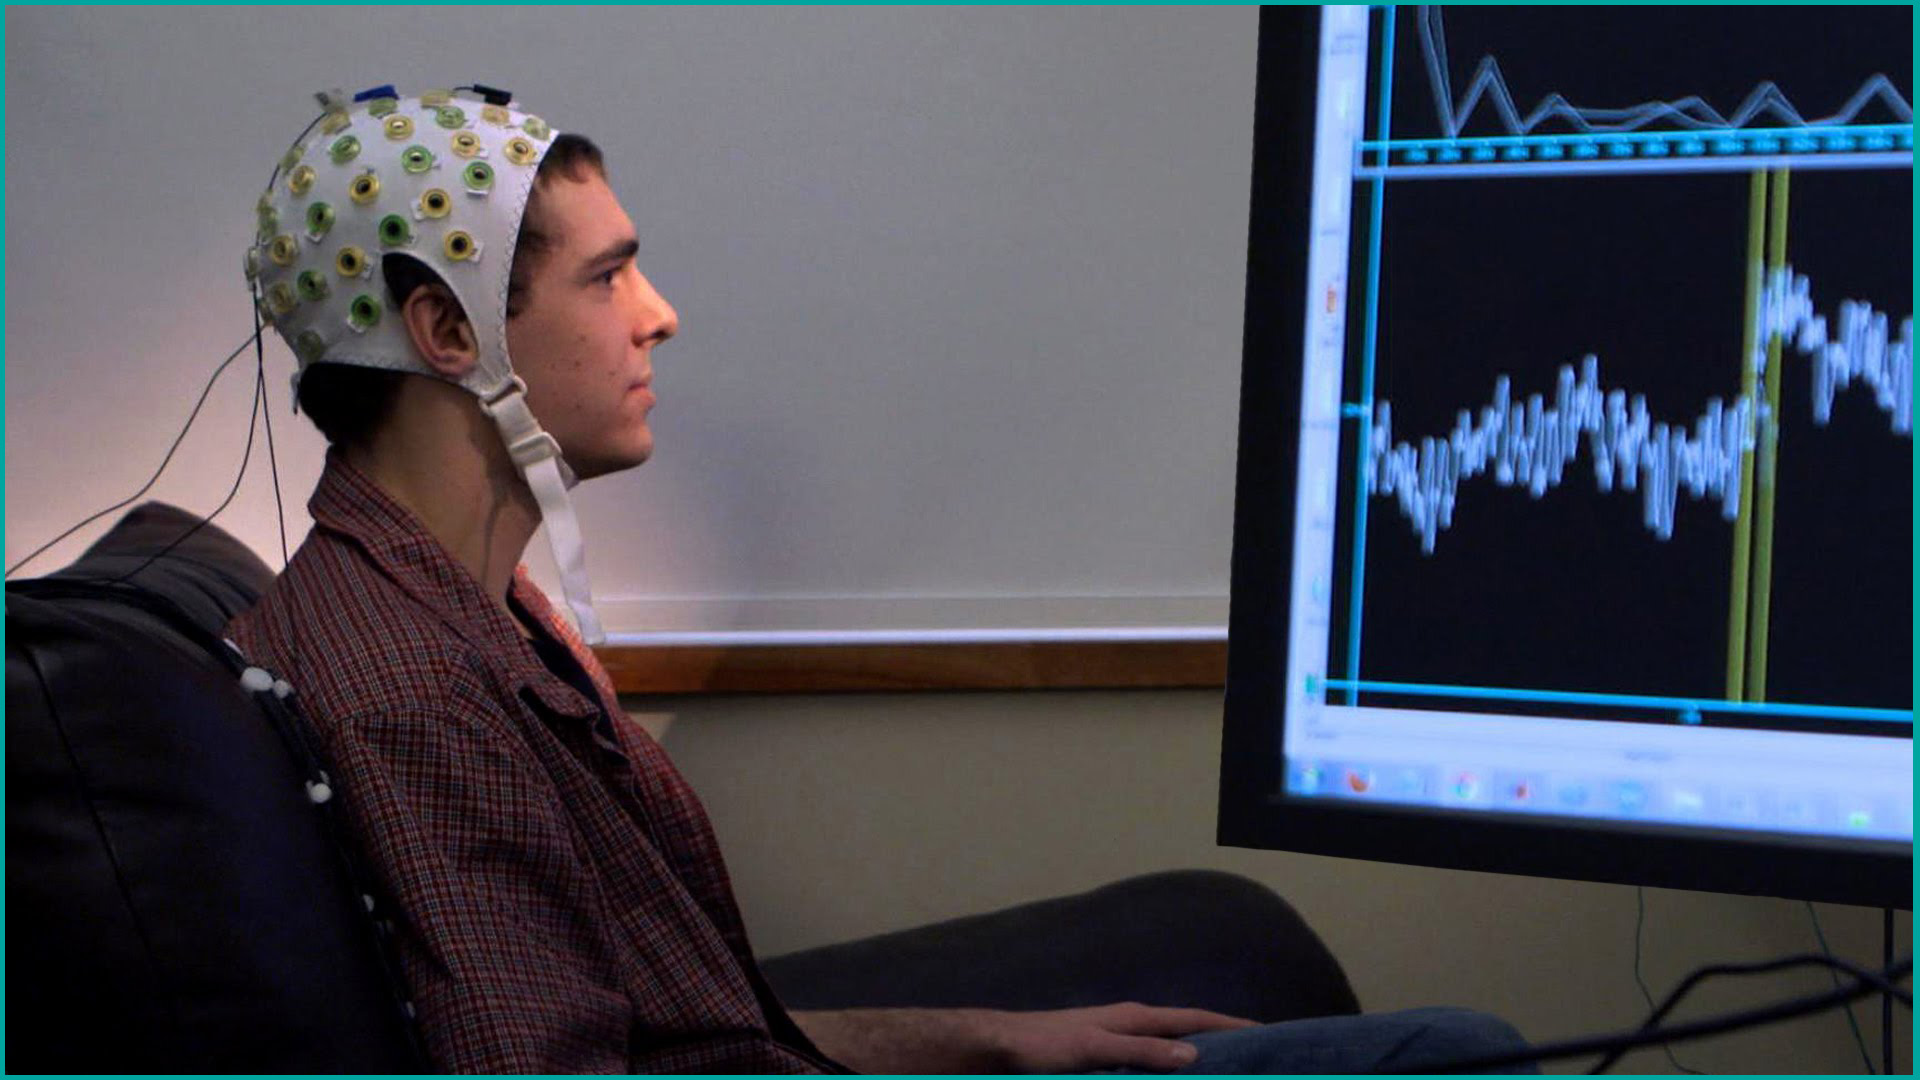

In [46]:
Image(filename = "../reports/figures/bci.jpg", width=800)

# Problem statement

The main problem that author is trying to solve is generating images based on human brain waves. This task is very hard because is very low dependency between visual stimulus and EEG signal. Dependency is getting higher when we have more accurate data acquisition device.

In order to complete this task author want to use deep learning generative models such as **VAE** or **GAN** in the future.

# Data measurement process

#### Stimulus : 

During experiment author as visual stimulus used images from **MNIST** database.It's a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.

Author during experiment used about 1200 mnist images. At the same time eeg signal was measured throught **[EMOTIV EPOC Neuroheadset](https://www.emotiv.com/epoc/)**.

#### About device : 


1. Sampling rate : 128 SPS
2. Number of electrodes : 14
3. Sampling Method : Sequential sampling. Single ADC
4. Filtering : Built-in digital 5th order Sinc filter

#### Experiment Details

1. Number of visual stimulus : 1200
2. Pause between images : 0.5s
3. Experiment time : 10 min
4. The number of participants : 1 - Me :)

# EEG Analysis

In order to perform mentioned task we need to analyse eeg data. The main points of this notebook include : 


1. Memory optimization
2. Check sampling
3. Frequency Analysis
3. Check missing data
4. Outlier Analysis
5. Data Distributions
6. Data dependency 

# Visual Stimuly Analysis (na koncu)

1. 
2. 

## Import libraries

In [42]:
# basic analysis
import os
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

#path
import sys
sys.path.append("..")

#math 
import math
from scipy.stats import chisquare
from scipy.stats import chi2

#custom
import config
from src.utils import memory as mem
from src.features import eeg
from src.visualization import visualize as vis

#others

import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
filename = "mnist-64s.csv"
csv_path = os.path.join(config.RAW_EEG_DIR,filename)
csv_path

'/home/michal/Desktop/ML_Projects/eeg2image/data/raw/EEG/mnist-64s.csv'

In [3]:
df = pd.read_csv(csv_path,index_col=0)
df_sensors = df[df.columns[0:14]] #only sensor values
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
0,4193.333008,4185.127930,4188.205078,4183.589844,4141.538574,4185.641113,4188.717773,4185.127930,4191.281738,4254.358887,4176.922852,4184.102539,4176.410156,4187.692383,0,5
1,4200.000000,4183.589844,4190.769043,4183.589844,4160.512695,4182.051270,4182.563965,4183.589844,4192.307617,4238.461426,4184.102539,4186.153809,4173.846191,4178.461426,0,5
2,4190.769043,4189.743652,4187.692383,4188.717773,4178.461426,4190.256348,4188.717773,4176.410156,4190.256348,4245.127930,4176.410156,4184.615234,4174.871582,4171.281738,0,5
3,4180.512695,4182.563965,4187.179199,4180.512695,4177.948730,4183.589844,4181.025391,4182.051270,4187.179199,4284.102539,4177.948730,4185.641113,4179.487305,4176.410156,0,5
4,4186.666504,4184.102539,4189.743652,4185.127930,4187.692383,4185.641113,4184.102539,4198.974121,4189.230469,4273.333008,4189.230469,4188.205078,4183.076660,4182.051270,0,5


In [4]:
df.describe(include="all")

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
count,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.00000
mean,4187.201069,4186.863044,4186.256877,4186.797570,4187.187587,4186.359638,4186.542157,4187.210165,4188.594993,4187.815484,4186.813654,4181.925026,4187.069658,4187.014156,599.500000,4.43750
std,36.799726,14.131410,33.108191,20.937706,21.116343,13.565859,14.907183,15.156324,2.350475,28.182697,24.635612,19.545867,24.966641,28.358797,346.412297,2.89071
min,4006.666504,4152.307617,3849.743408,3994.358887,4000.512695,4154.358887,4152.307617,4012.307617,4179.487305,3952.307617,3977.948730,3978.461426,4025.640869,3889.743408,0.000000,0.00000
25%,4170.769043,4176.410156,4174.358887,4177.436035,4175.384277,4176.410156,4175.384277,4177.948730,4187.179199,4173.333008,4175.897461,4170.256348,4175.897461,4173.846191,299.750000,2.00000
50%,4185.127930,4186.666504,4187.179199,4186.666504,4187.179199,4186.153809,4186.666504,4186.666504,4188.717773,4187.692383,4186.666504,4181.538574,4186.153809,4186.153809,599.500000,4.00000
75%,4198.974121,4197.948730,4200.512695,4195.897461,4199.487305,4196.922852,4198.461426,4197.436035,4190.256348,4201.538574,4197.436035,4192.820312,4196.410156,4197.948730,899.250000,7.00000
max,4741.538574,4231.281738,4433.846191,4719.487305,4416.410156,4223.076660,4230.256348,4309.230469,4205.127930,4704.102539,4586.666504,4327.692383,4429.230469,4425.127930,1199.000000,9.00000


## Check dtypes with max value of each feature 

In [5]:
mem.memory_usage(df)
df.agg(["dtypes","max"])

Memory usage 10.44 Mb


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
dtypes,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
max,4741.54,4231.28,4433.85,4719.49,4416.41,4223.08,4230.26,4309.23,4205.13,4704.1,4586.67,4327.69,4429.23,4425.13,1199,9


## Memory optimization

One of the drawbacks of Pandas is that by default the memory consumption of a DataFrame is very inefficient. When reading in a csv file the column types are inferred and are defaulted to the largest data type (int64, float64, object).
In order to solve this problem I downcast types to max value of each column.

In [6]:
df = mem.optimize_floats(df)
df = mem.optimize_ints(df)
mem.memory_usage(df)
df.agg(["dtypes","max"])

Memory usage 5.15 Mb


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
dtypes,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int8
max,4741.54,4231.28,4433.85,4719.49,4416.41,4223.08,4230.26,4309.23,4205.13,4704.1,4586.67,4327.69,4429.23,4425.13,1199,9


## How many observations we have ? 

In [7]:
print("Number of observations : ",df.shape[0])
print("Number of features : ",df.shape[1])

Number of observations :  76800
Number of features :  16


## How many images was presented during experiment ?

In [8]:
len(df.mnist_index.unique())

1200

## How many class data have ? 

In [9]:
print(f"Number of class : {df.mnist_class.nunique()}")

Number of class : 10


## What is the sampling frequency per visual stimulus ?

In [10]:
sampling = len(df[df.mnist_index == 0])
print(f"Sampling frequency = {sampling}[Hz]")

Sampling frequency = 64[Hz]


## Does all eeg batch contain 64 samples?

In [11]:
error_batch = eeg.check_sampling(df,sampling)
print(f"Len of eeg batch with sampling error : {len(error_batch)}")

Len of eeg batch with sampling error : 0


# Class inbalance

## How many samples our data provides per class? 

In [12]:
pd.DataFrame(df["mnist_class"].value_counts().sort_index()).T

,0,1,2,3,4,5,6,7,8,9
mnist_class,7488,9152,7616,7104,8256,6656,7040,9088,6656,7744


In [13]:
df.mnist_index.nunique()

1200

## Mean number of samples per class?

In [14]:
df["mnist_class"].value_counts().mean()

7680.0

##  Difference between sampling the most and the lowest represented class ?

In [15]:
lowest_samples = df["mnist_class"].value_counts().sort_index().min()
highest_samples = df["mnist_class"].value_counts().sort_index().max()
print(f"The least representative class : {lowest_samples}")
print(f"The most representative class : {highest_samples}")
print("The least representative class has about {}% fewer samples than the most representative class".format(round(100 - (6656*100)/9152),2))

The least representative class : 6656
The most representative class : 9152
The least representative class has about 27% fewer samples than the most representative class


As we can se we have unbalanced classes. Before adding data to model we need to balance our data. During preprocessing step we can do methods like : 

1. Upsamling 
2. Downsampling
3. Generate synthetic samples (SMOTE)

# Check missing data

In [16]:
eeg.check_missing_values(df).T

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,mnist_class,mnist_index
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dtype,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int8,int16


Na podstawie danych ktore otrzymalem nie stwierdza sie braku ich danych i koniecznosci ich uzupelniania 

# Outlier analysis 

Very common type of outlier during eeg measurement is something called **eeg artifact**. This is type of noise that comes from 2 type of source : 

#### Biological source :

1. Eye blinking,
2. Teeth clenching
3. Heart beating
4. Skeletal muscle tightening

#### Technical source :

1. Noise from power supply

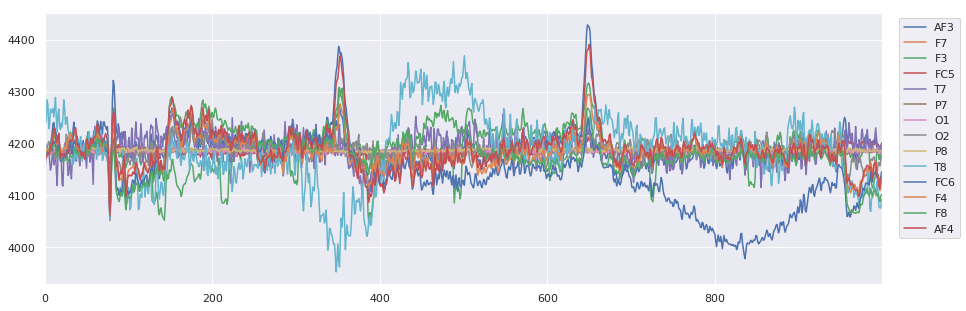

In [20]:
_ = df[df.columns[0:14]].iloc[0:1000].plot(figsize=(15,5)).legend(bbox_to_anchor=(1.1,1.0))
_ = plt.title("")

## Check outliers nummericaly

One of the most popular way to check outliers is comparing **mean** and **median** of features.
* If mean and median is equal it means that outliers probably not exist.
* If mean is bigger or lower than median it means that we have outliers in data

In [21]:
pd.DataFrame({"mean": df_sensors.mean(),
              "median" : df_sensors.median(),
              "diff" : df_sensors.mean()-df_sensors.median()})

,mean,median,diff
AF3,4187.201069,4185.127930,2.073139
F7,4186.863044,4186.666504,0.196540
F3,4186.256877,4187.179199,-0.922322
FC5,4186.797570,4186.666504,0.131066
T7,4187.187587,4187.179199,0.008388
P7,4186.359638,4186.153809,0.205829
O1,4186.542157,4186.666504,-0.124347
O2,4187.210165,4186.666504,0.543661
P8,4188.594993,4188.717773,-0.122781
T8,4187.815484,4187.692383,0.123101


As wee can se the difference between mean and median is very low but exist.
I concern 2 scenarios : 

 * There is a lot of outliers with low difference related to normal data points
 * There is a few samples of outliers with high value

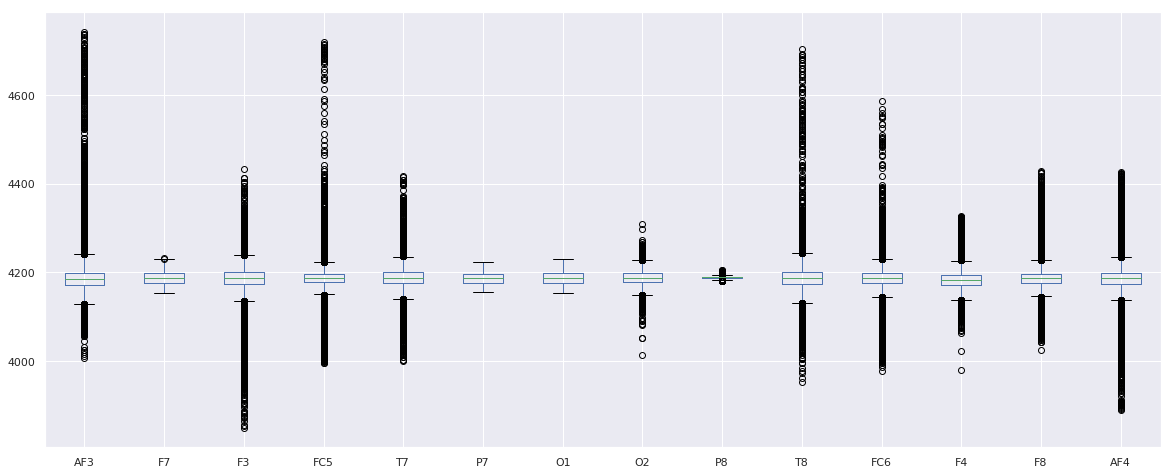

In [18]:
_ = df_sensors.boxplot(figsize=(20,8))

# First conclusions

1. As I mentioned before there is very lod distance between outliers and normal data points  
2. Based on IQR indicator we can se that about 50 % of data characterized by very low variability

3. Median of every electrod take place in the same point. All electrodes have the same baseline

4. **Electrodes variance is very low. This may be indicative of the low stimulus effect on brain**.

5. Electrodes F7,P7,01,P8 are characterized by close to zero variability. It can mean that something is wrong with this electrodes ( there are prone to biomedical artifacts)

## How to deal with this kind of outliers ?

Generally, in statistics and data science there are three accepted categories of outliers fall into : 

1. **Global outliers** (Type 1) - Value is far outside the entire of the data set
2. **Contextual outliers** (Type 2) - Value significanlty deviates from the rest of datapoints in the same context 
3. **Collective outliers** (Type 3) - Values as a collection deviate significantly from the entire data set, but the values of the individual data points are not themselves anomalous in either a contextual or global sense.

During artifacts detection I try to remove global outliers in the form of spikes in the signal 

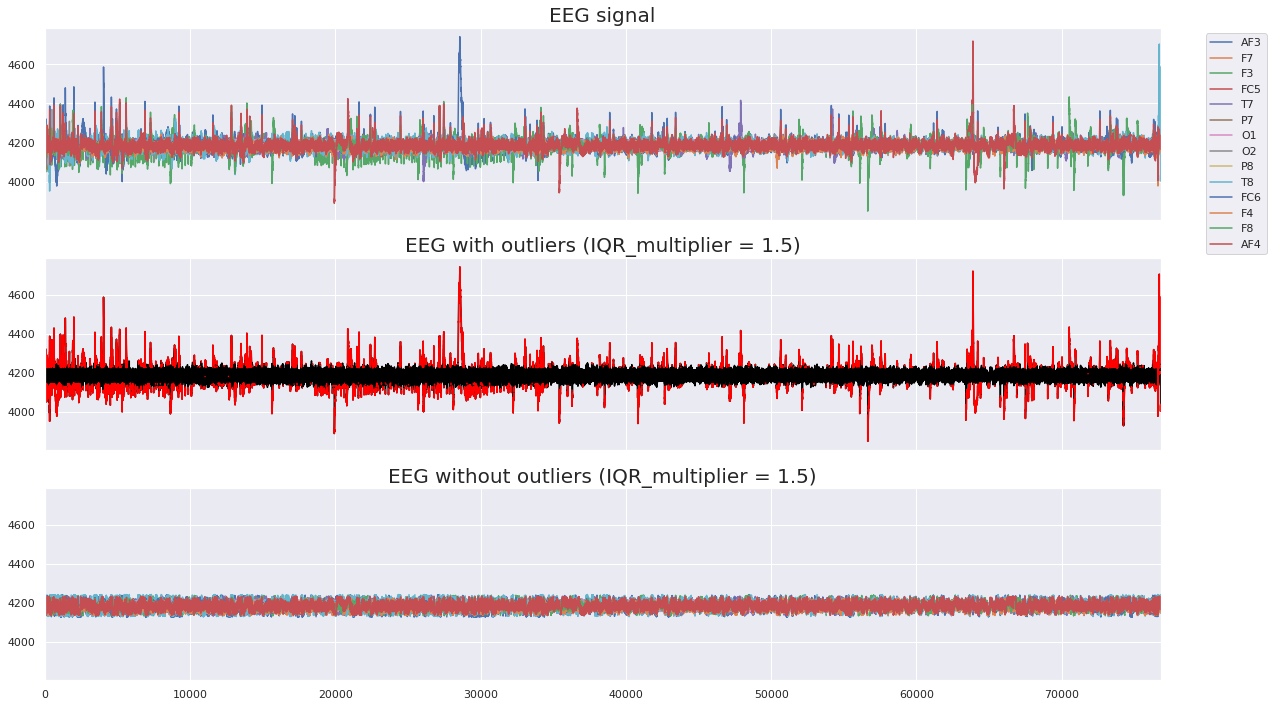

In [35]:
fig,axes = plt.subplots(3,1,figsize=(20,12),sharex=True)

# Plot EEG signal 
eeg_ax = axes[0]

_ = df_sensors.plot(grid=True,ax=eeg_ax).legend(bbox_to_anchor=(1.1,1.0))
_ = eeg_ax.set_title("EEG signal",size=20)

# Plot EEG with outliers
outliers_ax = axes[1]

IQR_MUL = 1.5
lower_outliers,upper_outliers = eeg.get_outliers_iqr(df,iqr_mul=IQR_MUL)

_ = df_sensors.plot(grid=True,color = "black",ax = outliers_ax,legend=False)
_ = df_sensors[lower_outliers | upper_outliers ].plot(color = "red",ax = outliers_ax,legend = False)
_ = outliers_ax.set_title(f"EEG with outliers (IQR_multiplier = {IQR_MUL})",size=20)

# Plot EEG without outliers

eeg_clean_ax = axes[2]
_ = df_sensors[(~upper_outliers & ~lower_outliers)].plot(ax = eeg_clean_ax,legend=False)
_ = eeg_clean_ax.set_title(f"EEG without outliers (IQR_multiplier = {IQR_MUL})",size=20)
down, up = axes[1].get_ylim() 
_ = eeg_clean_ax.set_ylim(down,up)

As we can se on characteristics above based on on IQR indicator we can filter artifacts from EEG signal. This method is very easy and in this case is very good. Let's see the efect of outlier detection closer.

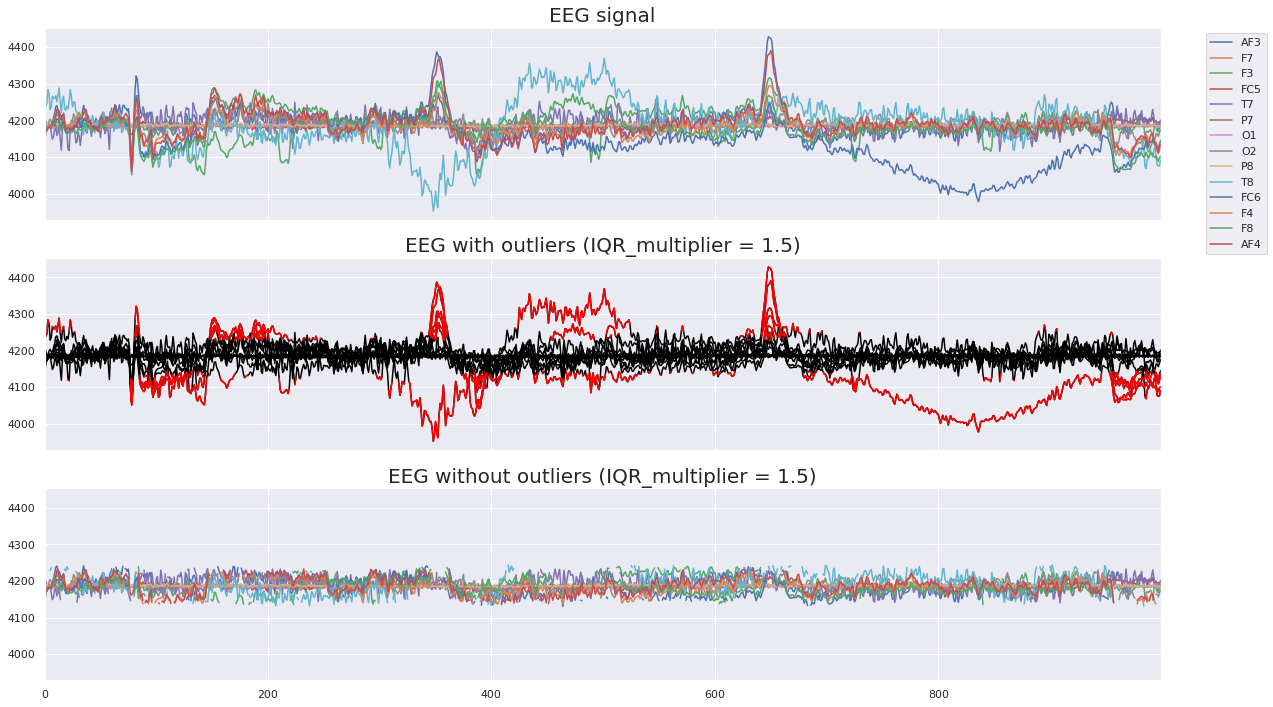

In [37]:
fig,axes = plt.subplots(3,1,figsize=(20,12),sharex=True)

n_samples = 1000
df_sensors_short = df_sensors[0:n_samples]

# Plot EEG signal 
eeg_ax = axes[0]

_ = df_sensors_short.plot(grid=True,ax=eeg_ax).legend(bbox_to_anchor=(1.1,1.0))
_ = eeg_ax.set_title("EEG signal",size=20)

# Plot EEG with outliers
outliers_ax = axes[1]

IQR_MUL = 1.5
lower_outliers,upper_outliers = eeg.get_outliers_iqr(df,iqr_mul=IQR_MUL)

_ = df_sensors_short.plot(grid=True,color = "black",ax = outliers_ax,legend=False)
_ = df_sensors_short[lower_outliers | upper_outliers ].plot(color = "red",ax = outliers_ax,legend = False)
_ = outliers_ax.set_title(f"EEG with outliers (IQR_multiplier = {IQR_MUL})",size=20)

# Plot EEG without outliers

eeg_clean_ax = axes[2]
_ = df_sensors_short[(~upper_outliers & ~lower_outliers)].plot(ax = eeg_clean_ax,legend=False)
_ = eeg_clean_ax.set_title(f"EEG without outliers (IQR_multiplier = {IQR_MUL})",size=20)
down, up = axes[1].get_ylim() 
_ = eeg_clean_ax.set_ylim(down,up)


As we can see on characteristics above the signal is much more clean than was before outlier detection. It prove that statistics method works very well on this kind of problem.

At this moment I don't see purpose to detect other kind of outliers because if we push data to VAE during encoding part model tri to perform dimensionality reduction based on most useful datapoints. It means that VAE like most Deep learning architectures perform feature selection and feature extraction automaticly.

## Data Distributions

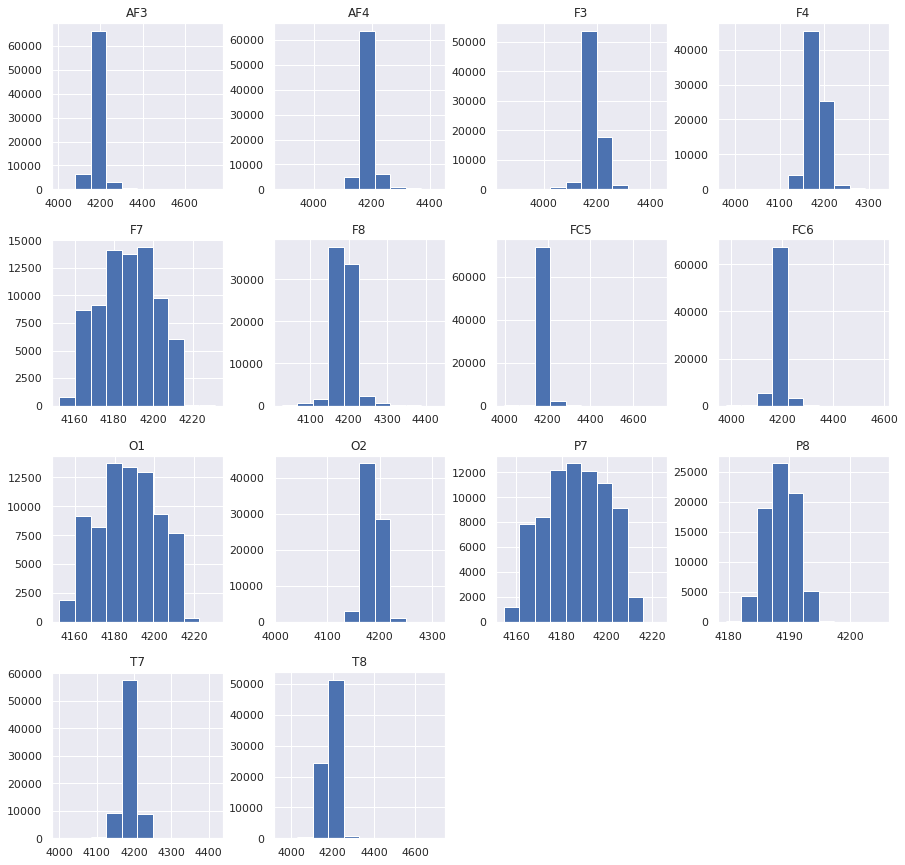

In [50]:
_ = df_sensors.hist(figsize=(15,15))

# komentarz 

- bardzo skupione
- probuja wygladac jak rozklad gausa
- Niektore sensory maja male rozproszenie
- Mozemy poprawic troche dystrybucje danych poprzez wykorzystnaie transforamcji typu BOX Cox lub tego drugiego

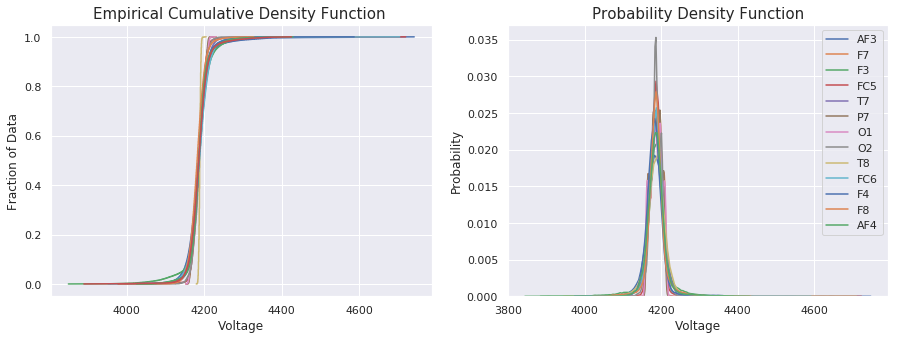

In [21]:
figure,(Ecdf,Pdf) = plt.subplots(1,2,figsize=(15,5))

## ECDF
for i,sensor in enumerate(df_sensors.columns):
    x,y = vis.ecdf(df_sensors[sensor])
    Ecdf.plot(x,y,label = sensor)


_ = Ecdf.set_title("Empirical Cumulative Density Function ",size=15)
_ = Ecdf.set_xlabel("Voltage")
_ = Ecdf.set_ylabel("Fraction of Data")

    
    
for i,sensor in enumerate(df_sensors.columns):
    if sensor != "P8":
        _ = sns.distplot(df_sensors[sensor],hist=False,label = sensor,ax=Pdf)
_ = Pdf.set_title("Probability Density Function",size=15)
_ = Pdf.set_xlabel("Voltage")
_ = Pdf.set_ylabel("Probability")


# komentarz
_ = Prawdopodobienstwo wystapienia outliera jest  bardzo male male
_ =  Funkcja gętości prawdopodobieństwa dla każdej cechy jest bardzo podobna ale jednak nie identyczna


# Feature dependency

The process of measurement is based on getting signal from each electrode and depend on signal between normal sensor and reference sensor(P3, P4)})
Due to process of measurement **is very high probability that our sensors are very correlated with each other**. 

<img src="../reports/figures/sensors2.png" style="height:250px" align = "center" >

## Check dependency between features

As we see before during data overwiew process our data from sensors are **continous type**. It means that we can check dependency between them. One of the most popular method to check dependency between continous features is  
**correlation**. Correlation is usually defined as a measure of the linear relationship between two quantitative variables (e.g., height and weight).

During experiment I focused on 2 indicators of correlation :

* **Pearson** - linear correlation
* **Spearman** - monotonic correlation

Let's plot heatmap of correlation and try to learn something new about eeg signal.

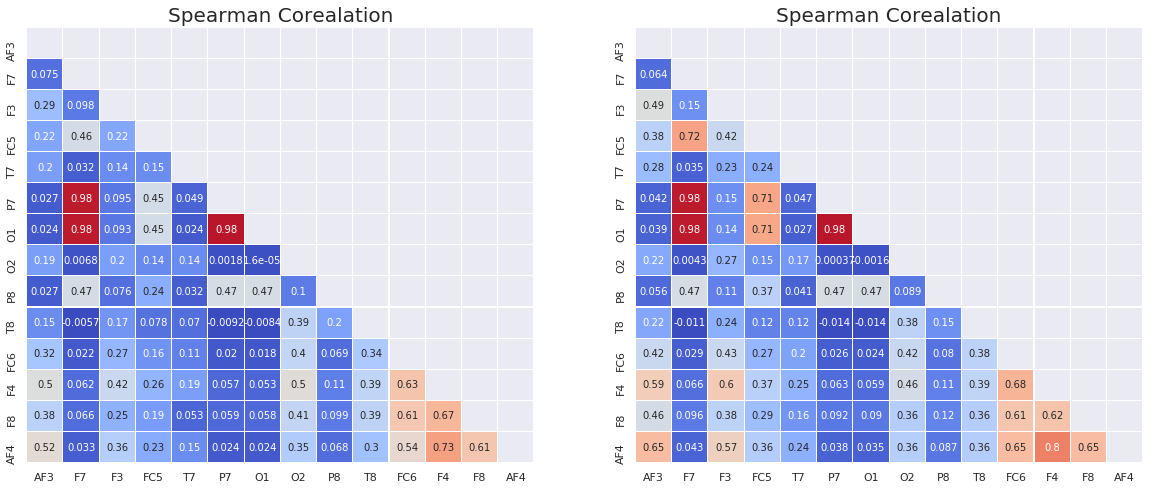

In [24]:
pearson,spearman = vis.plot_sensors_correlation(df_sensors,figsize=(20,8))

### Linear higly correlated features : 
* P7 - F7

* O1 - F7
* O1 - P7
* F4 - AF4

### Monotonic highly correlated features : 
* AF4 - AF3
* AF3- F4
* F4 - F3
* F4 - FC6

As we can se above on pearson corelation heatmap there is 3 or 4 electrodes with high corelations indicator. 
But if we look at spearman corelation indicator we can a few more corelation between sensors. It can mean that our outliers adding noise to signal values and linear dependency between them is smaller.

Let's inwestigate our sensors visually:

## Plot correlated features

In [88]:
# fig,axes = plt.subplots(1,3,figsize=(20,8))
# for index,sensors in enumerate(pearson.index):
#     if index == 3 : break
#     sns.regplot(x=sensors[0], y=sensors[1], data=df,ax=axes[index])

#     _ = plt.suptitle("Linear highly corelated features",size = 20)

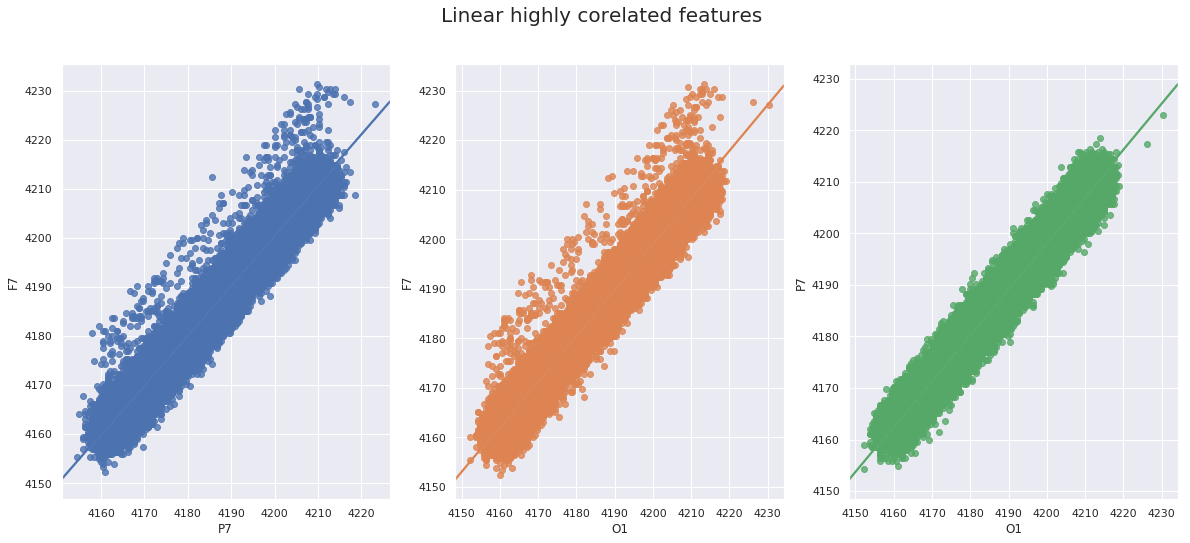

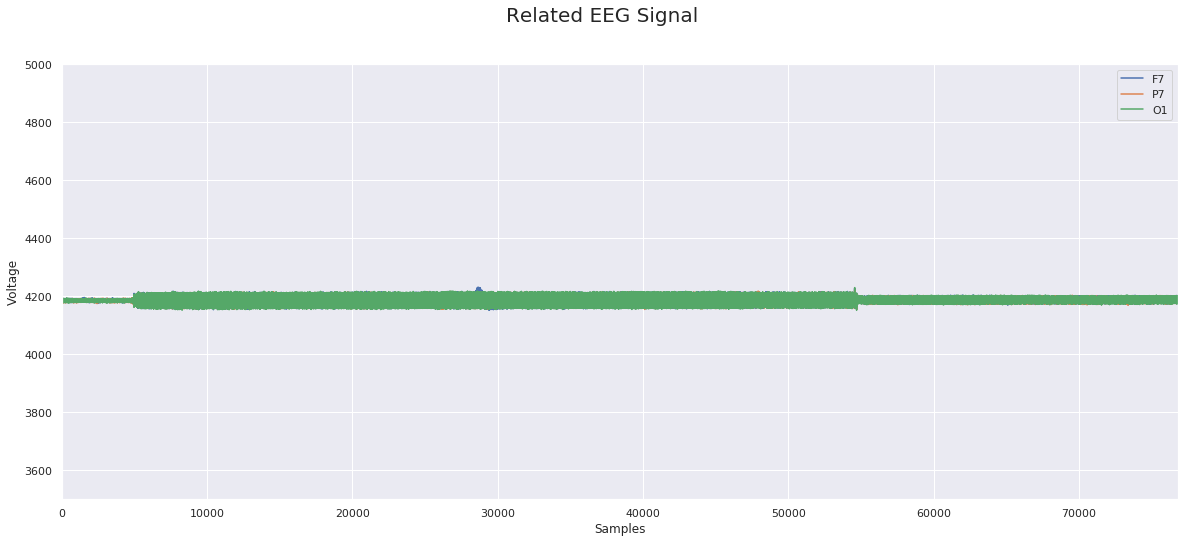

In [82]:
sns.regplot(x="P7", y="F7", data=df,ax=axes[0])
sns.regplot(x="O1", y="F7", data=df,ax=axes[1])
sns.regplot(x="O1", y="P7", data=df,ax=axes[2])

_ = plt.suptitle("Linear highly corelated features",size = 20)


# plot 
_ = df[["F7","P7","O1"]].plot(figsize=(20,8),grid=True)
_ = plt.suptitle("Related EEG Signal",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")
_ = plt.ylim(3500,5000)

As we can see on image above there is very high corelation between these features.
Due to very low variance I think that **these sensors don't work correctly**(they don't have outliers related with bio artifacts)

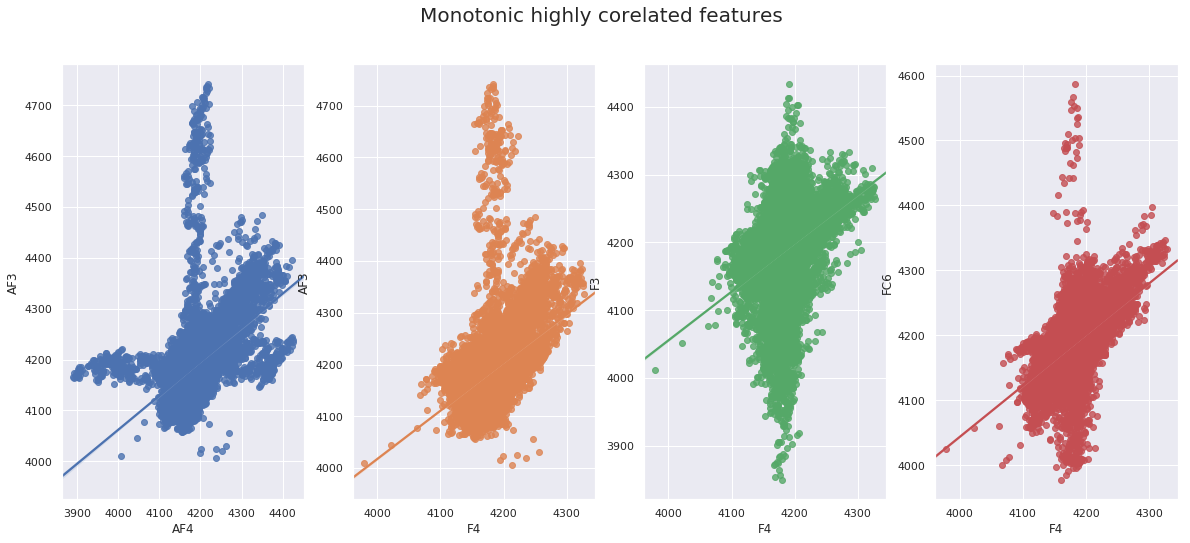

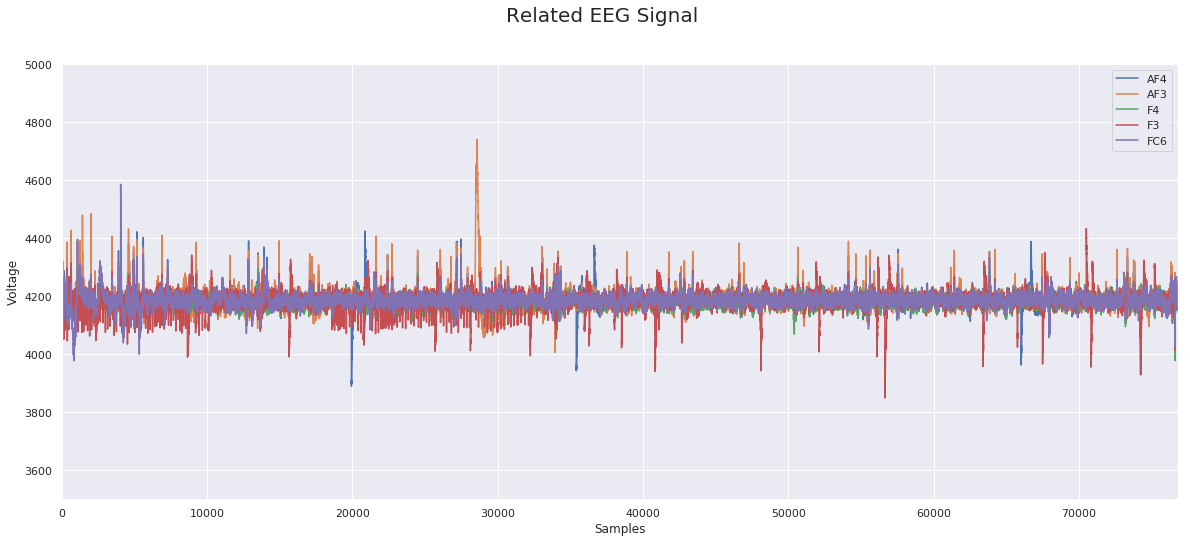

In [201]:
fig,axes = plt.subplots(1,4,figsize=(20,8))

sns.regplot(x="AF4", y="AF3", data=df,ax=axes[0])
sns.regplot(x="F4", y="AF3", data=df,ax=axes[1])
sns.regplot(x="F4", y="F3", data=df,ax=axes[2])
sns.regplot(x="F4", y="FC6",data=df,ax=axes[3])

_ = plt.suptitle("Monotonic highly corelated features",size = 20)

_ = df[["AF4","AF3","F4","F3","FC6"]].plot(figsize=(20,8),grid=True)
_ = plt.suptitle("Related EEG Signal",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")
_ = plt.ylim(3500,5000)

* As we can see on image above if at the some period of time outlier exist then we lost linear dependency between sensors.

* It's hard to say that coleration between sensors is evoked by external stimulus or is related to the method of data measurement - by signal reference.


# Feature dependence with target variable

**Stochastic dependence** 

A dependence between random variables that is expressed by a change of the conditional distribution of any of the variables when the other variables are altered.

**Corelation depencence**

In statistics, correlation or dependence is any statistical relationship, whether causal or not, between two random variables or bivariate data.



#### Check dependency between features and class label

In [89]:
print("Mean and std for reach class : ")
df.groupby("mnist_class").agg(["mean","std"])

Mean and std for reach class : 


AF3                      F7                      F3  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4182.323730  31.032862  4186.876465  13.876190  4186.949219   
1            4189.564453  44.187195  4187.008789  14.089030  4188.338867   
2            4188.332520  35.024960  4186.848145  14.584678  4186.260254   
3            4184.494629  26.761379  4186.761719  13.771214  4186.773926   
4            4186.383789  25.088062  4186.822266  13.843282  4185.897949   
5            4186.029297  30.287436  4186.787598  14.591815  4186.369629   
6            4185.231445  26.912369  4186.844727  14.194752  4185.636719   
7            4188.857422  48.916672  4186.929688  13.820323  4185.289062   
8            4190.409180  50.060062  4186.823242  14.429846  4181.587402   
9            4189.461426  34.489288  4186.867188  14.251288  4188.647949   

                                FC5                      T7             ...  \
                   std         mean        std         mean        std  ...   
mnist_class                                                             ...   
0            33.169662  4186.479492  27.077026  4187.549805  20.143246  ...   
1            30.760012  4186.401855  19.531374  4187.847656  21.367807  ...   
2            29.788773  4186.436523  13.490329  4186.301270  17.615995  ...   
3            38.296089  4189.394531  37.784855  4186.709961  19.517038  ...   
4            36.869865  4185.368652  14.848916  4188.235352  23.560923  ...   
5            32.635651  4187.070801  13.380219  4187.103027  28.059891  ...   
6            27.220390  4186.152344  20.211983  4186.442871  19.959208  ...   
7            31.473379  4186.884277  21.446499  4186.483887  18.388309  ...   
8            42.829735  4187.636230  14.082300  4185.975586  21.081125  ...   
9            25.743378  4186.598633  14.808169  4188.867676  20.460634  ...   

                     FC6                      F4                      F8  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4189.478027  30.318684  4182.432129  21.293253  4189.330078   
1            4188.218262  25.322517  4183.975098  21.382101  4188.957031   
2            4187.688477  21.773809  4181.655762  18.652767  4186.477051   
3            4180.307129  25.213198  4179.234375  18.948341  4185.754395   
4            4189.052246  20.269867  4183.136719  18.217224  4187.803711   
5            4186.415527  21.972933  4181.852539  18.087343  4186.748535   
6            4183.965332  30.275551  4180.851074  19.241560  4187.018066   
7            4183.941895  20.393364  4180.196289  18.154791  4183.289551   
8            4189.015137  23.132284  4182.572754  18.944660  4186.912109   
9            4189.708496  24.605873  4182.963379  21.275690  4188.554688   

                                AF4            mnist_index              
                   std         mean        std        mean         std  
mnist_class                                                             
0            28.569042  4188.232910  29.644375  588.452991  354.301388  
1            26.558748  4188.831543  36.478588  576.216783  357.791326  
2            23.240879  4187.941895  26.058208  588.831933  335.497791  
3            25.914215  4185.408691  24.000534  579.279279  360.099867  
4            24.683224  4187.632324  21.778856  621.302326  356.945721  
5            22.687456  4184.808105  28.057159  600.211538  312.482508  
6            24.795586  4184.936523  30.440733  601.463636  351.495426  
7            21.534557  4186.923340  26.689604  639.964789  342.480137  
8            23.253368  4185.368652  28.269978  614.644231  324.367844  
9            26.867504  4188.895508  28.063868  580.595041  351.454583  

[10 rows x 30 columns]

In [90]:
print("Mean and std difference for reach class : ")
df.groupby("mnist_class").agg(["mean","std"]).diff()

Mean and std difference for reach class : 


AF3                   F7                  F3             \
                 mean        std      mean       std      mean        std   
mnist_class                                                                 
0                 NaN        NaN       NaN       NaN       NaN        NaN   
1            7.240723  13.154333  0.132324  0.212840  1.389648  -2.409651   
2           -1.231934  -9.162235 -0.160645  0.495647 -2.078613  -0.971239   
3           -3.837891  -8.263580 -0.086426 -0.813464  0.513672   8.507317   
4            1.889160  -1.673317  0.060547  0.072068 -0.875977  -1.426224   
5           -0.354492   5.199373 -0.034668  0.748533  0.471680  -4.234215   
6           -0.797852  -3.375067  0.057129 -0.397063 -0.732910  -5.415260   
7            3.625977  22.004303  0.084961 -0.374429 -0.347656   4.252989   
8            1.551758   1.143391 -0.106445  0.609523 -3.701660  11.356356   
9           -0.947754 -15.570774  0.043945 -0.178557  7.060547 -17.086357   

                  FC5                   T7            ...       FC6            \
                 mean        std      mean       std  ...      mean       std   
mnist_class                                           ...                       
0                 NaN        NaN       NaN       NaN  ...       NaN       NaN   
1           -0.077637  -7.545652  0.297852  1.224562  ... -1.259766 -4.996166   
2            0.034668  -6.041045 -1.546387 -3.751812  ... -0.529785 -3.548708   
3            2.958008  24.294525  0.408691  1.901043  ... -7.381348  3.439388   
4           -4.025879 -22.935940  1.525391  4.043884  ...  8.745117 -4.943331   
5            1.702148  -1.468698 -1.132324  4.498968  ... -2.636719  1.703066   
6           -0.918457   6.831764 -0.660156 -8.100683  ... -2.450195  8.302618   
7            0.731934   1.234516  0.041016 -1.570898  ... -0.023438 -9.882187   
8            0.751953  -7.364199 -0.508301  2.692816  ...  5.073242  2.738920   
9           -1.037598   0.725869  2.892090 -0.620491  ...  0.693359  1.473589   

                   F4                  F8                 AF4             \
                 mean       std      mean       std      mean        std   
mnist_class                                                                
0                 NaN       NaN       NaN       NaN       NaN        NaN   
1            1.542969  0.088848 -0.373047 -2.010294  0.598633   6.834213   
2           -2.319336 -2.729334 -2.479980 -3.317869 -0.889648 -10.420380   
3           -2.421387  0.295574 -0.722656  2.673336 -2.533203  -2.057674   
4            3.902344 -0.731117  2.049316 -1.230991  2.223633  -2.221678   
5           -1.284180 -0.129881 -1.055176 -1.995768 -2.824219   6.278303   
6           -1.001465  1.154217  0.269531  2.108130  0.128418   2.383574   
7           -0.654785 -1.086769 -3.728516 -3.261028  1.986816  -3.751129   
8            2.376465  0.789869  3.622559  1.718811 -1.554688   1.580374   
9            0.390625  2.331030  1.642578  3.614136  3.526855  -0.206110   

            mnist_index             
                   mean        std  
mnist_class                         
0                   NaN        NaN  
1            -12.236208   3.489938  
2             12.615150 -22.293535  
3             -9.552653  24.602076  
4             42.023046  -3.154145  
5            -21.090787 -44.463213  
6              1.252098  39.012918  
7             38.501152  -9.015289  
8            -25.320558 -18.112293  
9            -34.049189  27.086739  

[10 rows x 30 columns]

* Based on very simmilar mean and standard deviation for all class, it can be determined that there is a **stochastic relationship**.

* But if we look at differences between previously mentioned indicators it can be determined that this stochastic relationship is very weak. It means that it can be difficult to generate images based on EEG from this part of data.

* Frankly speaking differences between indicators can be caused by noise of biomedical source.


# Image Analysis 

During experiment I use mnist dataset containts handwritten digits between 0-9.

In [489]:
from keras.datasets import mnist
(x_train, y_train), (_,_) = mnist.load_data()
x_train = x_train[0:1202]
y_train = y_train[0:1202]

In [490]:
print("image shape : ",x_train[0].shape) 

image shape :  (28, 28)


## Check Data Visually

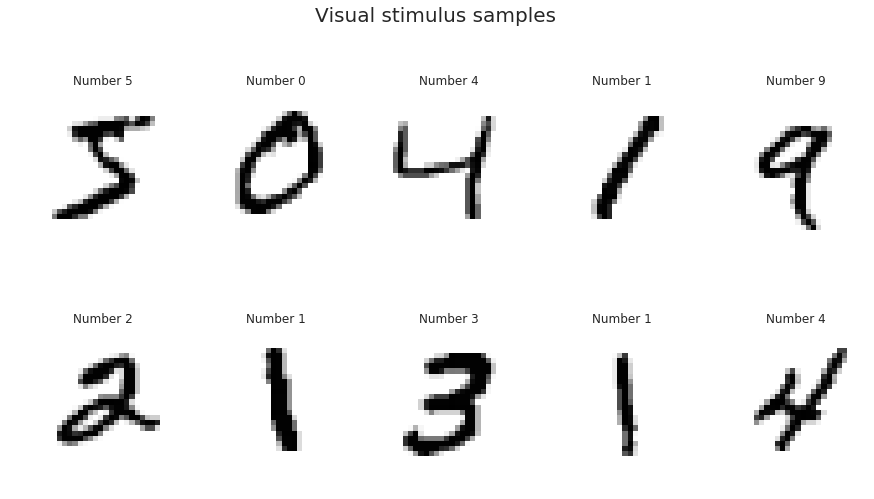

In [493]:
plt.figure(figsize=(15,8))
plt.suptitle("Visual stimulus samples",size = 20)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Number {y_train[i]}")

# Data preprocessing advice : 

1. Don't try remove outliers. They can have some useful information for VAE. If you want remove outliers (biomedical artifacts) from signal IQR indicator is quite good 
2. You should delete electrodes with very low variance(not informative) but VAE selects features 4 you.
3. #Loss function can go up with images very similar to each other (for example 1 and 7 or 3 and 9 ).You can delete this example after training to improve your model
4. Please standarize eeg in the same range as images [0-1]
5. You have unbalanced dataset. In order to balance it you can use something like SMOOTH or try to upsample data
6. If your model don't have good quality indicator don't be nervous. Corelation between EEG signal and IMG is only half of percent 0.5%